In [1]:
import pandas as pd
import numpy as np
import cv2
import glob
import imutils
from imutils import paths
import os
import os.path

## Extracting letters from each captcha for training the model

In [2]:
SOLVED_CAPTCHA_FOLDER = "solved-captchas"
OUTPUT_FOLDER = "extracted_letters"


# Get the path of all the solved captcha images
solved_captchas = glob.glob(os.path.join(SOLVED_CAPTCHA_FOLDER, "*"))
counts = {}

# loop over the image paths
for (i, captcha) in enumerate(solved_captchas):
    print("processing image {}/{}".format(i + 1, len(solved_captchas)))

    
    # grab the base filename as the text
    filename = os.path.basename(captcha)
    captcha_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # applying threshold
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]

     # finding the contours
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creating empty list for holding the coordinates of the letters
    letter_image_regions = []

    # Now we will loop through each of the contours and extract the letter
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # checking if any counter is too wide
        # if countour is too wide then there could be two letters joined together or are very close to each other
        if w / h > 1.25:
            # Split it in half into two letter regions
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            
            letter_image_regions.append((x, y, w, h))
            

    
    # Sort the detected letter images based on the x coordinate to make sure
    # we get them from left-to-right so that we match the right image with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    # Save each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]


        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # creating different output folder for storing different letters
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count)))
        cv2.imwrite(p, letter_image)

        # increment the count
        counts[letter_text] = count + 1


processing image 1/939
processing image 2/939
processing image 3/939
processing image 4/939
processing image 5/939
processing image 6/939
processing image 7/939
processing image 8/939
processing image 9/939
processing image 10/939
processing image 11/939
processing image 12/939
processing image 13/939
processing image 14/939
processing image 15/939
processing image 16/939
processing image 17/939
processing image 18/939
processing image 19/939
processing image 20/939
processing image 21/939
processing image 22/939
processing image 23/939
processing image 24/939
processing image 25/939
processing image 26/939
processing image 27/939
processing image 28/939
processing image 29/939
processing image 30/939
processing image 31/939
processing image 32/939
processing image 33/939
processing image 34/939
processing image 35/939
processing image 36/939
processing image 37/939
processing image 38/939
processing image 39/939
processing image 40/939
processing image 41/939
processing image 42/939
p

processing image 442/939
processing image 443/939
processing image 444/939
processing image 445/939
processing image 446/939
processing image 447/939
processing image 448/939
processing image 449/939
processing image 450/939
processing image 451/939
processing image 452/939
processing image 453/939
processing image 454/939
processing image 455/939
processing image 456/939
processing image 457/939
processing image 458/939
processing image 459/939
processing image 460/939
processing image 461/939
processing image 462/939
processing image 463/939
processing image 464/939
processing image 465/939
processing image 466/939
processing image 467/939
processing image 468/939
processing image 469/939
processing image 470/939
processing image 471/939
processing image 472/939
processing image 473/939
processing image 474/939
processing image 475/939
processing image 476/939
processing image 477/939
processing image 478/939
processing image 479/939
processing image 480/939
processing image 481/939


processing image 779/939
processing image 780/939
processing image 781/939
processing image 782/939
processing image 783/939
processing image 784/939
processing image 785/939
processing image 786/939
processing image 787/939
processing image 788/939
processing image 789/939
processing image 790/939
processing image 791/939
processing image 792/939
processing image 793/939
processing image 794/939
processing image 795/939
processing image 796/939
processing image 797/939
processing image 798/939
processing image 799/939
processing image 800/939
processing image 801/939
processing image 802/939
processing image 803/939
processing image 804/939
processing image 805/939
processing image 806/939
processing image 807/939
processing image 808/939
processing image 809/939
processing image 810/939
processing image 811/939
processing image 812/939
processing image 813/939
processing image 814/939
processing image 815/939
processing image 816/939
processing image 817/939
processing image 818/939


## Preparing training data

In [3]:
letter_folder = 'extracted_letters'

#creating empty lists for storing image data and labels
data = []
labels = []
for image in paths.list_images(letter_folder):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (30,30))
    
    # adding a 3rd dimension to the image
    img = np.expand_dims(img, axis = 2)
    
    #grabing the name of the letter based on the folder it is present in
    label = image.split(os.path.sep)[-2]
    
    # appending to the empty lists
    data.append(img)
    labels.append(label)

#converting data and labels to np array
data = np.array(data, dtype = "float")
labels = np.array(labels)

print(data.shape, labels.shape)
    

(4695, 30, 30, 1) (4695,)


In [4]:
#scaling the values of  data between 0 and 1
data = data/255.0

In [5]:
# Split the training data into separate train and test sets
from sklearn.model_selection import train_test_split
(train_x, val_x, train_y, val_y) = train_test_split(data, labels, test_size=0.2, random_state=0)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

(3756, 30, 30, 1) (939, 30, 30, 1) (3756,) (939,)


In [6]:
# one hot encoding our target variable 'labels'
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer().fit(train_y)
train_y = lb.transform(train_y)
val_y = lb.transform(val_y)
print(train_y.shape, val_y.shape)

(3756, 9) (939, 9)


## Model Building

In [7]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [8]:
model = Sequential()
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(30, 30, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(9, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               313728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [9]:
# using early stoping for avoiding overfitting
estop = EarlyStopping(patience=10, mode='min', min_delta=0.001, monitor='val_loss')

In [10]:
model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=32, epochs=50, verbose=1, callbacks = [estop])

Train on 3756 samples, validate on 939 samples
Epoch 1/50
3756/3756 [==============================] - 4s 1ms/step - loss: 0.3539 - acc: 0.8972 - val_loss: 0.0480 - val_acc: 0.9968
Epoch 2/50
3756/3756 [==============================] - 1s 250us/step - loss: 0.0197 - acc: 0.9981 - val_loss: 0.0504 - val_acc: 0.9968
Epoch 3/50
3756/3756 [==============================] - 1s 255us/step - loss: 0.0213 - acc: 0.9979 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 4/50
3756/3756 [==============================] - 1s 245us/step - loss: 0.0268 - acc: 0.9976 - val_loss: 0.0444 - val_acc: 0.9968
Epoch 5/50
3756/3756 [==============================] - 1s 249us/step - loss: 0.0193 - acc: 0.9981 - val_loss: 0.0449 - val_acc: 0.9968
Epoch 6/50
3756/3756 [==============================] - 1s 253us/step - loss: 0.0180 - acc: 0.9987 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 7/50
3756/3756 [==============================] - 1s 250us/step - loss: 0.0189 - acc: 0.9987 - val_loss: 0.0473 - val_acc: 0.9968
Epo

### Testing model on an unseen captcha

CAPTCHA text is: 66372


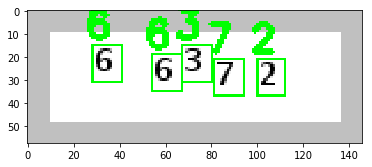

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
# Load the image and convert it to grayscale
image = cv2.imread('./unsolved-captchas/0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

# threshold the image
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]

# find the contours
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    
letter_image_regions = []

# Now we can loop through each of the contours and extract the letter

for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    
    # checking if any counter is too wide
    # if countour is too wide then there could be two letters joined together or are very close to each other
    if w / h > 1.25:
        # Split it in half into two letter regions
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        letter_image_regions.append((x, y, w, h))
            

# Sort the detected letter images based on the x coordinate to make sure
# we get them from left-to-right so that we match the right image with the right letter  

letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

# Create an output image and a list to hold our predicted letters
output = cv2.merge([gray] * 3)
predictions = []
    
# Creating an empty list for storing predicted letters
predictions = []
    
# Save out each letter as a single image
for letter_bounding_box in letter_image_regions:
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

    letter_image = cv2.resize(letter_image, (30,30))
        
    # Turn the single image into a 4d list of images
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)

    # making prediction
    pred = model.predict(letter_image)
        
    # Convert the one-hot-encoded prediction back to a normal letter
    letter = lb.inverse_transform(pred)[0]
    predictions.append(letter)


    # draw the prediction on the output image
    cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
    cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

# Print the captcha's text
captcha_text = "".join(predictions)
print("CAPTCHA text is: {}".format(captcha_text))

# Show the annotated image
plt.imshow(output)

### Making predictions on test data

In [12]:
test_image_folder = 'unsolved-captchas'
OUTPUT_FOLDER = 'predicted captchas'
test_captcha_images = glob.glob(os.path.join(test_image_folder, "*"))

In [13]:
# loop over the image paths
for (i, image) in enumerate(test_captcha_images):
    print("processing image {}/{}".format(i + 1, len(test_captcha_images)))

    # Load the image and convert it to grayscale
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    letter_image_regions = []

    # Now we can loop through each of the contours and extract the letter
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # checking if any counter is too wide
        # if countour is too wide then there could be two letters joined together or are very close to each other
        if w / h > 1.25:
            # Split it in half into two letter regions
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))
            

    
    # Sort the detected letter images based on the x coordinate to make sure
    # we get them from left-to-right so that we match the right image with the right letter  
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    # Creating an empty list for storing predicted letters
    predictions = []
    
    # Save out each letter as a single image
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        letter_image = cv2.resize(letter_image, (30,30))
        
        # Turn the single image into a 4d list of images
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # making prediction
        pred = model.predict(letter_image)
        
        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(pred)[0]
        predictions.append(letter)

        
    # joining predicted captcha's text
    captcha_text = "".join(predictions)
    
    # Get the folder to save the image in
    save_path = os.path.join(OUTPUT_FOLDER, captcha_text)
    
    p = os.path.join(save_path+'.png' )
    #writing the image to the output folder
    cv2.imwrite(p, img)


processing image 1/1500
processing image 2/1500
processing image 3/1500
processing image 4/1500
processing image 5/1500
processing image 6/1500
processing image 7/1500
processing image 8/1500
processing image 9/1500
processing image 10/1500
processing image 11/1500
processing image 12/1500
processing image 13/1500
processing image 14/1500
processing image 15/1500
processing image 16/1500
processing image 17/1500
processing image 18/1500
processing image 19/1500
processing image 20/1500
processing image 21/1500
processing image 22/1500
processing image 23/1500
processing image 24/1500
processing image 25/1500
processing image 26/1500
processing image 27/1500
processing image 28/1500
processing image 29/1500
processing image 30/1500
processing image 31/1500
processing image 32/1500
processing image 33/1500
processing image 34/1500
processing image 35/1500
processing image 36/1500
processing image 37/1500
processing image 38/1500
processing image 39/1500
processing image 40/1500
processin

processing image 335/1500
processing image 336/1500
processing image 337/1500
processing image 338/1500
processing image 339/1500
processing image 340/1500
processing image 341/1500
processing image 342/1500
processing image 343/1500
processing image 344/1500
processing image 345/1500
processing image 346/1500
processing image 347/1500
processing image 348/1500
processing image 349/1500
processing image 350/1500
processing image 351/1500
processing image 352/1500
processing image 353/1500
processing image 354/1500
processing image 355/1500
processing image 356/1500
processing image 357/1500
processing image 358/1500
processing image 359/1500
processing image 360/1500
processing image 361/1500
processing image 362/1500
processing image 363/1500
processing image 364/1500
processing image 365/1500
processing image 366/1500
processing image 367/1500
processing image 368/1500
processing image 369/1500
processing image 370/1500
processing image 371/1500
processing image 372/1500
processing i

processing image 664/1500
processing image 665/1500
processing image 666/1500
processing image 667/1500
processing image 668/1500
processing image 669/1500
processing image 670/1500
processing image 671/1500
processing image 672/1500
processing image 673/1500
processing image 674/1500
processing image 675/1500
processing image 676/1500
processing image 677/1500
processing image 678/1500
processing image 679/1500
processing image 680/1500
processing image 681/1500
processing image 682/1500
processing image 683/1500
processing image 684/1500
processing image 685/1500
processing image 686/1500
processing image 687/1500
processing image 688/1500
processing image 689/1500
processing image 690/1500
processing image 691/1500
processing image 692/1500
processing image 693/1500
processing image 694/1500
processing image 695/1500
processing image 696/1500
processing image 697/1500
processing image 698/1500
processing image 699/1500
processing image 700/1500
processing image 701/1500
processing i

processing image 997/1500
processing image 998/1500
processing image 999/1500
processing image 1000/1500
processing image 1001/1500
processing image 1002/1500
processing image 1003/1500
processing image 1004/1500
processing image 1005/1500
processing image 1006/1500
processing image 1007/1500
processing image 1008/1500
processing image 1009/1500
processing image 1010/1500
processing image 1011/1500
processing image 1012/1500
processing image 1013/1500
processing image 1014/1500
processing image 1015/1500
processing image 1016/1500
processing image 1017/1500
processing image 1018/1500
processing image 1019/1500
processing image 1020/1500
processing image 1021/1500
processing image 1022/1500
processing image 1023/1500
processing image 1024/1500
processing image 1025/1500
processing image 1026/1500
processing image 1027/1500
processing image 1028/1500
processing image 1029/1500
processing image 1030/1500
processing image 1031/1500
processing image 1032/1500
processing image 1033/1500
proc

processing image 1308/1500
processing image 1309/1500
processing image 1310/1500
processing image 1311/1500
processing image 1312/1500
processing image 1313/1500
processing image 1314/1500
processing image 1315/1500
processing image 1316/1500
processing image 1317/1500
processing image 1318/1500
processing image 1319/1500
processing image 1320/1500
processing image 1321/1500
processing image 1322/1500
processing image 1323/1500
processing image 1324/1500
processing image 1325/1500
processing image 1326/1500
processing image 1327/1500
processing image 1328/1500
processing image 1329/1500
processing image 1330/1500
processing image 1331/1500
processing image 1332/1500
processing image 1333/1500
processing image 1334/1500
processing image 1335/1500
processing image 1336/1500
processing image 1337/1500
processing image 1338/1500
processing image 1339/1500
processing image 1340/1500
processing image 1341/1500
processing image 1342/1500
processing image 1343/1500
processing image 1344/1500
p